`Designed for Brightway2` \
`v1` \
`13-04-2023` \
`Authors: Michael Weinold (@michaelweinold) and Chris Mutel (@cmutel)`

# Imports

In [27]:
import zipfile
import os
import stats_arrays

In [1]:
import bw2data
import bw2io
import bw2calc
import bw2analyzer

In [2]:
# type hints
from bw2data.backends.peewee.database import SQLiteBackend
from bw2data.backends.peewee.proxies import Activity

# Projects

In Brightway2, a project is a separate directory with its own copies of LCI databases, LCIA methods, and any other data you use. Each research project or article should probably be its own project, so that any changes you want to make will not interfere with your other work. The default project is called ``default``:

In [3]:
print(bw2data.projects.current)
print(bw2data.projects.dir)

default
/Users/michaelweinold/Library/Application Support/Brightway3/default.c21f969b5f03d33d43e04f8f136e7682


We can create a new project:

In [4]:
bw2data.projects.set_current("bw2intro")

And list the available projects:

In [5]:
bw2data.projects

Brightway2 projects manager with 7 objects:
	3.8
	3.9
	3.9.1
	bw2intro
	default
	ecoinvent35
	ecoinvent38
Use `projects.report()` to get a report on all projects.

Projects can be deleted:

In [6]:
bw2data.projects.delete_project(name = 'default', delete_dir = True)

'bw2intro'

# Biosphere Dataset

The `bw2io.bw2setup()` function can import some basic data: a database of elementary flows, some LCIA methods, and some metadata used for importing other databases.

In [7]:
bw2io.bw2setup()

Biosphere database already present!!! No setup is needed


In [8]:
db: SQLiteBackend = bw2data.Database("biosphere3")

The number of biosphere flows is:

In [9]:
len(db)

4709

We can get a random flow and the associated name, unit and categories:

In [10]:
random_flow: Activity = db.random()

In [11]:
random_flow

'Acetonitrile' (kilogram, None, ('water',))

In [12]:
print(random_flow['name'])
print(random_flow['unit'])
print(random_flow['categories'])

Acetonitrile
kilogram
('water',)


Brightway2 uses keys to identify datasets. Each dataset is identified by a combination of its database and some unique code. The code can be anything - a number, a UUID, or just a name.

In [18]:
random_flow.key

('biosphere3', '4d07c245-a030-5399-a74e-aaac30014ec3')

# LCIA Methods Dataset

The `bw2io.bw2setup()` function also installed a large number of LCIA methods:

In [19]:
bw2data.methods

Methods dictionary with 762 objects, including:
	('CML v4.8 2016', 'acidification', 'acidification (incl. fate, average Europe total, A&B)')
	('CML v4.8 2016', 'climate change', 'global warming potential (GWP100)')
	('CML v4.8 2016', 'ecotoxicity: freshwater', 'freshwater aquatic ecotoxicity (FAETP inf)')
	('CML v4.8 2016', 'ecotoxicity: marine', 'marine aquatic ecotoxicity (MAETP inf)')
	('CML v4.8 2016', 'ecotoxicity: terrestrial', 'terrestrial ecotoxicity (TETP inf)')
	('CML v4.8 2016', 'energy resources: non-renewable', 'abiotic depletion potential (ADP): fossil fuels')
	('CML v4.8 2016', 'eutrophication', 'eutrophication (fate not incl.)')
	('CML v4.8 2016', 'human toxicity', 'human toxicity (HTP inf)')
	('CML v4.8 2016', 'material resources: metals/minerals', 'abiotic depletion potential (ADP): elements (ultimate reserves)')
	('CML v4.8 2016', 'ozone depletion', 'ozone layer depletion (ODP steady state)')
Use `list(this object)` to get the complete list.

The number of methods is:

In [20]:
len(bw2data.methods)

762

Because LCIA methods have many different impact categories, they are identified not by a single label, but by a list of labels. Let's look at an example:

In [15]:
method_key: tuple = bw2data.methods.random()
method_key

('ReCiPe 2016 v1.03, endpoint (I) no LT',
 'total: human health no LT',
 'human health no LT')

In this case, the LCIA method has three levels of specificity, from the general name (first level) to the specific impact category (last level). There is nothing magic about three levels - you could have one, or one hundred - but Brightway2 expects that LCIA methods will be a list of text labels ``('like', 'this')``.

We can load the method data, show a sample.

Method data has the format:

    biosphere flow, numeric value, location

Where:

* `biosphere flow` is a dataset from any database which is used as a biosphere flow.
* `numeric value` can be either a fixed number or an uncertainty distribution.
* `location` is optional; the default value is that this characterization factor is valid everywhere.

The method data format is pretty flexible, and the following are all acceptable:

    [('biosphere', 'CO2'), 1.0],                                             # Default location
    [('biosphere', 'CO2'), 1.0, 'Australia, mate!'],                         # Custom location
    [('biosphere', 'CO2'), 1.0, ('Population density', 'Raster cell 4,2')],  # Location inside a geocollection
    [('biosphere', 'CO2'), {'amount': 1.0, 'uncertainty type': 0}],          # Uncertain characterization factor

[Geocollections](http://brightway2-regional.readthedocs.org/#spatial-scales-geocollections) are needed for regionalized LCA.

If you are wondering why we need to identify biosphere flows like `('biosphere', '2fe885840cebfcc7d56b607b0acd9359')`, this is a good question! The short answer is that there is no single field that uniquely identifies biosphere flows or activities. The longer answer [is in the manual](https://docs.brightwaylca.org/intro.html#uniquely-identifying-activities).

Brightway2 is designed to be flexible enough for many different problems. Therefore, there are no limits on what constitutes a biosphere flow. Rather, anything that is linked to in a biosphere exchange will be put in the biosphere matrix. We installed a database called `biosphere3`, but you can define new flows in a database alongside process datasets, or create your own biosphere database.

In [40]:
method_data = Method(method_key).load()
print("Number of CFs:", len(method_data))
method_data[:20]

Number of CFs: 792


[(('biosphere3', 'f681eb3c-854a-4f78-bcfe-76dfbcf9df3c'), 2.22107612959e-06),
 (('biosphere3', 'e2d860e3-1038-4386-a5f1-25ad75d18bbd'), 2.14240130852e-08),
 (('biosphere3', '9fbec2f4-6b42-4e63-9573-14e04befe20f'), 3.97819564124e-09),
 (('biosphere3', '99c07b66-c039-4896-866d-06abdaa9d46a'), 5.39267954175e-08),
 (('biosphere3', 'cdcdbfc9-3d5f-4e78-8033-8dbecbb2cfec'), 0.000350740558118),
 (('biosphere3', '5ad58fcc-e9ba-4155-a3c9-e4ffb3065a6f'), 1.11019655928e-06),
 (('biosphere3', 'eb23cf3a-b866-458d-94b3-9aee4145fcc9'), 1.10822971148e-07),
 (('biosphere3', '1f130425-11f9-4ec2-8d2f-d282acaacf5c'), 9.67186558462e-09),
 (('biosphere3', '56dea244-390c-4f56-8b11-c8de2902816e'), 9.7246994101e-08),
 (('biosphere3', '7ed6dc0d-9c2e-4046-a44b-e8a708c2081e'), 0.00140792037782),
 (('biosphere3', '42f51ad5-6190-4641-b961-f411310554e9'), 9.70801684411e-05),
 (('biosphere3', 'ec9b8886-22ef-452b-9347-88dd1ab3a6a5'), 7.68478964109e-06),
 (('biosphere3', 'fbe48c6a-321d-44ae-8883-b6fa4e0f4e77'), 4.441349

# Importing the `FORWAST` LCI Database

We will use the FORWAST database, as it is both a high quality, comprehensive LCI database, and freely available. [FORWAST](http://forwast.brgm.fr/Overview.asp) is a physical MRIO table for Europe. It can be downloaded directly from the [2.-0 website](http://lca-net.com/projects/show/forwast/).

In [20]:
filepath = bw2data.utils.download_file("forwast.bw2package.zip", url="http://lca-net.com/wp-content/uploads/")
dirpath = os.path.dirname(filepath)
zipfile.ZipFile(filepath).extractall(dirpath)
bw2io.BW2Package.import_file(os.path.join(dirpath, "forwast.bw2package"))

Title: Writing activities to SQLite3 database:
  Started: 04/13/2023 09:21:47
  Finished: 04/13/2023 09:21:48
  Total time elapsed: 00:00:00
  CPU %: 100.00
  Memory %: 1.26


[Brightway2 SQLiteBackend: forwast]

In [21]:
bw2data.databases

Databases dictionary with 2 object(s):
	biosphere3
	forwast

# Searching Datasets

The `bw2data.Database.search` function covers the following data fields:
* `name`
* `comment`
* `product`
* `categories`
* `location`

In [22]:
bw2data.Database("forwast").search("food")

['_26 Food preparations n.e.c., DK' (kilogram, GLO, ['Input Output', 'Denmark 2003']),
 '_26 Food preparations n.e.c., EU27' (kilogram, GLO, ['Input Output', 'EU27 2003']),
 '116 Waste treatment, Landfill of waste, Food, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003']),
 '101 Waste treatment, Incineration of waste, Food, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003']),
 '103 Waste treatment, Composting of food waste, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003']),
 '100 Waste treatment, Biogasification of food waste, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003']),
 '112 Waste treatment, Composting of food waste, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003']),
 '_92 Waste treatment, Incineration of waste, Food, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003']),
 '107 Waste treatment, Landfill of waste, Food, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003']),
 '109 Waste treatment, Biogasification of food waste, EU27' (kilogram, GLO, ['Input Output', 

You can also use the `*` wildcard in search queries. By default, the function returns the first 25 search results.

In [23]:
bw2data.Database("biosphere3").search("carb*", limit=10)

['Carbon monoxide, from soil or biomass stock' (kilogram, None, ('air', 'non-urban air or from high stacks')),
 'Carboxin' (kilogram, None, ('water',)),
 'Carbon dioxide, fossil' (kilogram, None, ('air',)),
 'Carbon monoxide, from soil or biomass stock' (kilogram, None, ('air', 'lower stratosphere + upper troposphere')),
 'Carbon dioxide, in air' (kilogram, None, ('natural resource', 'in air')),
 'Carbon monoxide, non-fossil' (kilogram, None, ('air', 'low population density, long-term')),
 'Carbon dioxide, to soil or biomass stock' (kilogram, None, ('soil', 'agricultural')),
 'Boron carbide' (kilogram, None, ('air', 'non-urban air or from high stacks')),
 'Carbendazim' (kilogram, None, ('water', 'ground-')),
 'Carboxin' (kilogram, None, ('air', 'non-urban air or from high stacks'))]

Searches can also be filtered (where only the results that meet the specified criteria are *included*) or masked (where results that meet the specified criteria are *excluded*). You can specify inclusion or exclusion criteria for fields with `filter` and `mask`:

In [24]:
bw2data.Database("biosphere3").search("carbon", filter={"categories": 'forestry'})

Excluding 77 filtered results


['Carbon' (kilogram, None, ('soil', 'forestry')),
 'Carbon dioxide, to soil or biomass stock' (kilogram, None, ('soil', 'forestry'))]

In [25]:
bw2data.Database("biosphere3").search("carbon", limit=10, mask={"categories": 'forestry'})

Excluding 2 filtered results


['Carbon' (kilogram, None, ('soil', 'industrial')),
 'Carbon' (kilogram, None, ('soil',)),
 'Carbon' (kilogram, None, ('soil', 'agricultural')),
 'Elemental carbon' (kilogram, None, ('water',)),
 'Carbon disulfide' (kilogram, None, ('air', 'urban air close to ground')),
 'Organic carbon' (kilogram, None, ('water', 'ground-')),
 'Elemental carbon' (kilogram, None, ('air', 'urban air close to ground')),
 'Organic carbon' (kilogram, None, ('air', 'urban air close to ground')),
 'Carbon disulfide' (kilogram, None, ('water', 'surface water')),
 'Carbon disulfide' (kilogram, None, ('water', 'ground-'))]

## Changing iteration order

You can also change the way that processes are iterated over in the database. The default order is random:

In [75]:
db = Database("forwast")

def print_10(db):
    for i, x in enumerate(db):
        if i < 10:
            print(x)
        else:
            break
            
print_10(db)

'_90 Financial intermediation, EU27' (EUR2003, GLO, ['Input Output', 'EU27 2003'])
'111 Waste treatment, Biogasification of sewage slugde, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003'])
'120 Waste treatment, Land application of compost, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003'])
'_24 Sugar, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003'])
'_66 Electricity, steam and hot water, DK' (kilowatt hour, GLO, ['Input Output', 'Denmark 2003'])
'131 Household use, Meals, DK' (EUR2003, GLO, ['Input Output', 'Denmark 2003'])
'_42 Rubber and plastic products, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003'])
'_45 Cement, virgin, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003'])
'_88 Cargo handling, harbours and travel agencies, EU27' (EUR2003, GLO, ['Input Output', 'EU27 2003'])
'__7 Horticulture, orchards etc., DK' (kilogram, GLO, ['Input Output', 'Denmark 2003'])


In [76]:
print_10(db)

'_36 Refined petroleum products and fuels, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003'])
'140 Household use, Meals, EU27' (EUR2003, GLO, ['Input Output', 'EU27 2003'])
'127 Waste treatment, Landfill of waste, Oil' (kilogram, Hazardous waste, EU27, ['Input Output', 'EU27 2003'])
'113 Waste treatment, Landfill of waste, Metals nec, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003'])
'_58 Recycling of copper basic, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003'])
'_25 Animal feeds, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003'])
'129 Waste treatment, Land application of compost, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003'])
'105 Waste treatment, Incineration of waste, Glass' (kilogram, inert, EU27, ['Input Output', 'EU27 2003'])
'_45 Cement, virgin, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003'])
'_14 Copper from mine, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003'])


You can sort by `location`, `name`, `product` (reference product), or `type`, by specifying the `order_by` property.

In [78]:
db.order_by = "location"
print_10(db)

'_78 Buildings, residential, EU27' (EUR2003, GLO, ['Input Output', 'EU27 2003'])
'106 Waste treatment, Incineration of waste, Textiles, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003'])
'_83 Retail  trade and repair services, EU27' (EUR2003, GLO, ['Input Output', 'EU27 2003'])
'_54 Recycling of copper basic, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003'])
'_41 Plastics basic, virgin, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003'])
'_19 Meat products, Fish, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003'])
'126 Household use, Education, DK' (EUR2003, GLO, ['Input Output', 'Denmark 2003'])
'117 Waste treatment, Landfill of waste, Wood, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003'])
'_77 Water, fresh, EU27' (EUR2003, GLO, ['Input Output', 'EU27 2003'])
'134 Household use, Communication, EU27' (EUR2003, GLO, ['Input Output', 'EU27 2003'])


If the above seems wrong, remember that the names start with `100`, `101`, etc.

Set `.order_by = None` to remove any ordering.

In [79]:
db.order_by = None

Because accessing activities in the database is quite fast, you can also filter the activities you want by just iterating over the entire database:

In [99]:
bw2data.Database('fowast').search('electricity')

[]

In [105]:
bw2data.Database('forwast').search('electr*')

['_68 Electrical machinery n.e.c., EU27' (kilogram, GLO, ['Input Output', 'EU27 2003']),
 '_59 Electrical machinery n.e.c., DK' (kilogram, GLO, ['Input Output', 'Denmark 2003']),
 '_75 Electricity, steam and hot water, EU27' (kilowatt hour, GLO, ['Input Output', 'EU27 2003']),
 '_66 Electricity, steam and hot water, DK' (kilowatt hour, GLO, ['Input Output', 'Denmark 2003'])]

In [92]:
my_activities = [x for x in db if 'Electr' in x['name']]
my_activities

['_75 Electricity, steam and hot water, EU27' (kilowatt hour, GLO, ['Input Output', 'EU27 2003']),
 '_66 Electricity, steam and hot water, DK' (kilowatt hour, GLO, ['Input Output', 'Denmark 2003']),
 '_68 Electrical machinery n.e.c., EU27' (kilogram, GLO, ['Input Output', 'EU27 2003']),
 '_59 Electrical machinery n.e.c., DK' (kilogram, GLO, ['Input Output', 'Denmark 2003'])]

# Basic LCA calculations

Let's pick and random process and LCIA method:

In [111]:
process: Activity = Database("forwast").random()
process

'_67 Gas, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003'])

In [110]:
from bw2data.backends.peewee.proxies import Activity

In [107]:
type(process)

bw2data.backends.peewee.proxies.Activity

A brief review of LCA calculations:

In matrix-based LCA, we construct a *technosphere* matrix, which describes the inputs needed to produce different products (e.g. cars need metal and electricity), and a *biosphere* matrix, which describes the emissions and resource consumption associated with the production of each product (e.g. car manufacturing releases air emissions). These two matrices come from the life cycle inventory database(s). We also have a *functional unit*, which is what we are trying to assess, e.g. one car. We then calculate the *life cycle inventory* (LCI) by first solving the linear system of the technosphere matrix and the functional unit, and then by multiplying the biosphere matrix.

To do *life cycle impact assessment* (LCIA), we multiply the life cycle inventory by a matrix of characterization factors, which tell how bad different emissions and resource consumptions are.

For more details on the math, see the [manual](https://docs.brightwaylca.org/lca.html).

So, our first step is to specify the functional unit, which is relatively easy:

In [112]:
functional_unit = {process: 1}

We can then instantiate our [LCA object](https://docs.brightwaylca.org/technical/bw2calc.html#lca). 

In [177]:
lca = bw2calc.LCA(demand = functional_unit, method = method_key)

In [178]:
type(lca)

bw2calc.lca.LCA

And do the LCI and LCIA calculations:

In [179]:
lca.lci()

In [180]:
lca.lcia()

In [181]:
lca.score

0.16681173303620245

In [ ]:
lca.lci()
lca.lcia()

Finally, we can print the LCA score:

In [126]:
lca.score

0.0

You can reuse the same matrices but change the functional unit by using the `redo_lci` and `redo_lcia` functions:

In [184]:
new_process = Database("forwast").random()
print(new_process)
lca.redo_lcia({new_process: 1})
lca.score

'107 Waste treatment, Incineration of waste, Wood, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003'])


-1.9815068474766349

# Looking into the LCA object

Let's see what is in this `LCA` thing, anyway. Put your cursor in the following cell and hit tab:

In [186]:
lca.

So, there is a lot. Let's look at a few things:

* The technosphere matrix

In [187]:
lca.technosphere_matrix

<277x277 sparse matrix of type '<class 'numpy.float64'>'
	with 36825 stored elements in Compressed Sparse Row format>

* The biosphere matrix

In [188]:
lca.biosphere_matrix

<20x277 sparse matrix of type '<class 'numpy.float64'>'
	with 2170 stored elements in Compressed Sparse Row format>

* The characterization matrix

In [189]:
lca.characterization_matrix

<20x20 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>

# Graphing matrices

Sometimes it can be helpful to visualize both the inputs and calculation results.

In [190]:
%matplotlib inline

If you get some warnings here, you can ignore them again.

In [191]:
from bw2analyzer.matrix_grapher import SparseMatrixGrapher

First, let's look at the technosphere matrix.

You can pass in a filename to get a higher resolution figure saved as a file.

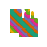

In [192]:
SparseMatrixGrapher(lca.technosphere_matrix).ordered_graph()

Not so interesting - I am sure your inventory data will be much nicer. The problem is that this is an IO matrix, so there is a value at each point, even if it is small, and this graph only shows where values are or aren't zero. For example, here is the same graph for ecoinvent 3.2 (cutoff):

<img src="https://brightwaylca.org/data/ecoinvent-32-cutoff.png">

You can also graph the biosphere and any other LCA matrices.

# Contribution analysis

We can calculate the most important activities and biosphere flows.

In [193]:
import bw2analyzer

Most important activities

In [194]:
bw2analyzer.ContributionAnalysis().annotated_top_processes(lca)

[(-1.9352269361068175,
  -4.785996584968771,
  '_75 Electricity, steam and hot water, EU27' (kilowatt hour, GLO, ['Input Output', 'EU27 2003'])),
 (-0.028480940744074236,
  -0.6466936816450355,
  '_10 Coal, lignite, peat, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003'])),
 (0.024491842149862632,
  0.03414256711552382,
  '_47 Cement, virgin, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003'])),
 (-0.011943944298877072,
  -0.16644433181721183,
  '_11 Crude petroleum and natural gas, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003'])),
 (-0.01061947546500826,
  -0.06230120412581188,
  '_37 Refined petroleum products and fuels, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003'])),
 (-0.00469552535500119,
  -0.05984950875191787,
  '_76 Gas, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003'])),
 (-0.0034281350631684714,
  -0.0016714322119391182,
  '_85 Land transport and transport via pipelines, EU27' (EUR2003, GLO, ['Input Output', 'EU27 2003'])),
 (0.0034274036078531076,
  0.99928

Most important biosphere flows

In [197]:
bw2analyzer.ContributionAnalysis().annotated_top_emissions(lca)

ValueError: Inexact indices into sparse matrices are not allowed

# Monte Carlo LCA

Unfortunately, the `forwast` database doesn't unclude uncertainty. Let's put some in anyways, using the utility function [uncertainify](https://docs.brightwaylca.org/technical/bw2data.html#bw2data.utils.uncertainify).

In [ ]:
uncertain_db = Database("forwast uncertain +")
uncertain_db.write(
    uncertain_db.relabel_data(
        bw2data.utils.uncertainify(
            Database("forwast").load(), 
            stats_arrays.NormalUncertainty
        ), 
        "forwast uncertain +" 
    )
)

We can now calculate some Monte Carlo iterations for a random activity.

In [ ]:
mc = MonteCarloLCA(demand={uncertain_db.random(): 1}, method=method_key)
mc.load_data()
for x in range(10):
    print(next(mc))